#### Task1

✅ Image loaded successfully
✅ Detected 263 symbols
✅ Found 1 unique symbol types

🎯 Total unique detected patterns: 1


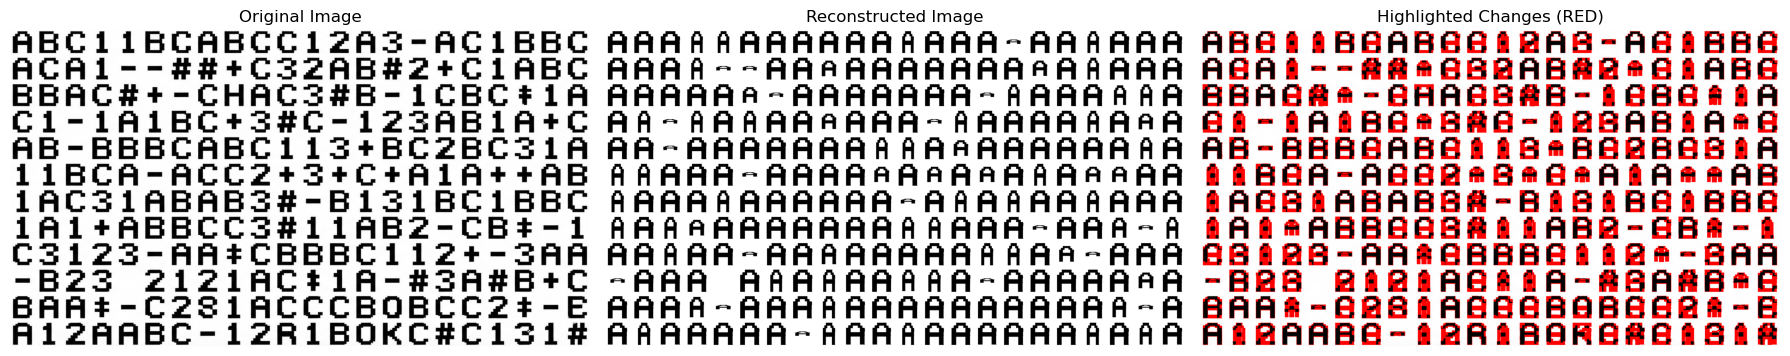

In [1]:
# ============================================================
# PATTERN SUBSTITUTION / SYMBOL GROUPING FROM IMAGE
# WITH CHANGE HIGHLIGHTING
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# MAIN FUNCTION
# ------------------------------------------------------------
def solve_pattern_substitution(image_path, threshold=0.15):

    if not os.path.exists(image_path):
        print("❌ Image path is wrong. File not found!")
        return None, None, 0

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print("✅ Image loaded successfully")

    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    components = []

    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area < 5:
            continue

        roi = binary[y:y+h, x:x+w]
        resized = cv2.resize(roi, (20, 20), interpolation=cv2.INTER_AREA)

        components.append({
            "bbox": (x, y, w, h),
            "original": roi,
            "resized": resized,
            "group": -1
        })

    print(f"✅ Detected {len(components)} symbols")

    # ---------- GROUPING ----------
    prototypes = []

    for comp in components:
        matched = False
        for proto_img, proto_id in prototypes:
            diff = cv2.absdiff(comp["resized"], proto_img)
            mse = np.mean(diff) / 255.0

            if mse < threshold:
                comp["group"] = proto_id
                matched = True
                break

        if not matched:
            new_id = len(prototypes)
            prototypes.append((comp["resized"], new_id))
            comp["group"] = new_id

    print(f"✅ Found {len(prototypes)} unique symbol types")

    # ---------- RECONSTRUCTION ----------
    reconstructed = np.ones_like(img) * 255

    for comp in components:
        x, y, w, h = comp["bbox"]
        proto_roi = next(c["original"] for c in components if c["group"] == comp["group"])
        proto_resized = cv2.resize(proto_roi, (w, h), interpolation=cv2.INTER_AREA)
        reconstructed[y:y+h, x:x+w] = cv2.bitwise_not(proto_resized)

    return img, reconstructed, len(prototypes)


# ------------------------------------------------------------
# EXECUTION
# ------------------------------------------------------------

IMAGE_PATH = "test.jpeg"   # 👈 change path here
THRESHOLD = 100

original, result, groups = solve_pattern_substitution(IMAGE_PATH, THRESHOLD)

if result is not None:

    print(f"\n🎯 Total unique detected patterns: {groups}")

    # ---------- CHANGE DET says ----------
    diff = cv2.absdiff(original, result)
    _, diff_mask = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Convert original to color
    highlight = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)

    # Highlight changes in RED
    highlight[diff_mask == 255] = [0, 0, 255]

    # ---------- DISPLAY ----------
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(original, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Reconstructed Image")
    plt.imshow(result, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Highlighted Changes (RED)")
    plt.imshow(cv2.cvtColor(highlight, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### Task 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


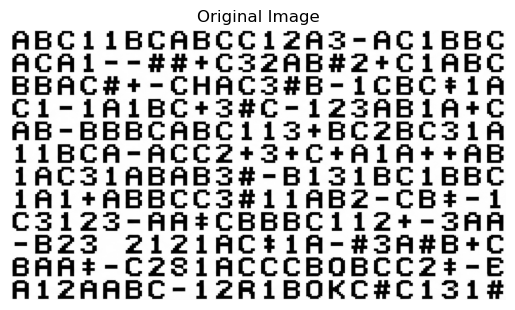

In [3]:
img = cv2.imread("test.jpeg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()


✅ Image loaded
Quality 90 -> PSNR: 47.14, SSIM: 0.9951
Quality 70 -> PSNR: 37.68, SSIM: 0.9664
Quality 50 -> PSNR: 35.12, SSIM: 0.9515
Quality 30 -> PSNR: 32.68, SSIM: 0.9282
Quality 10 -> PSNR: 27.51, SSIM: 0.8635


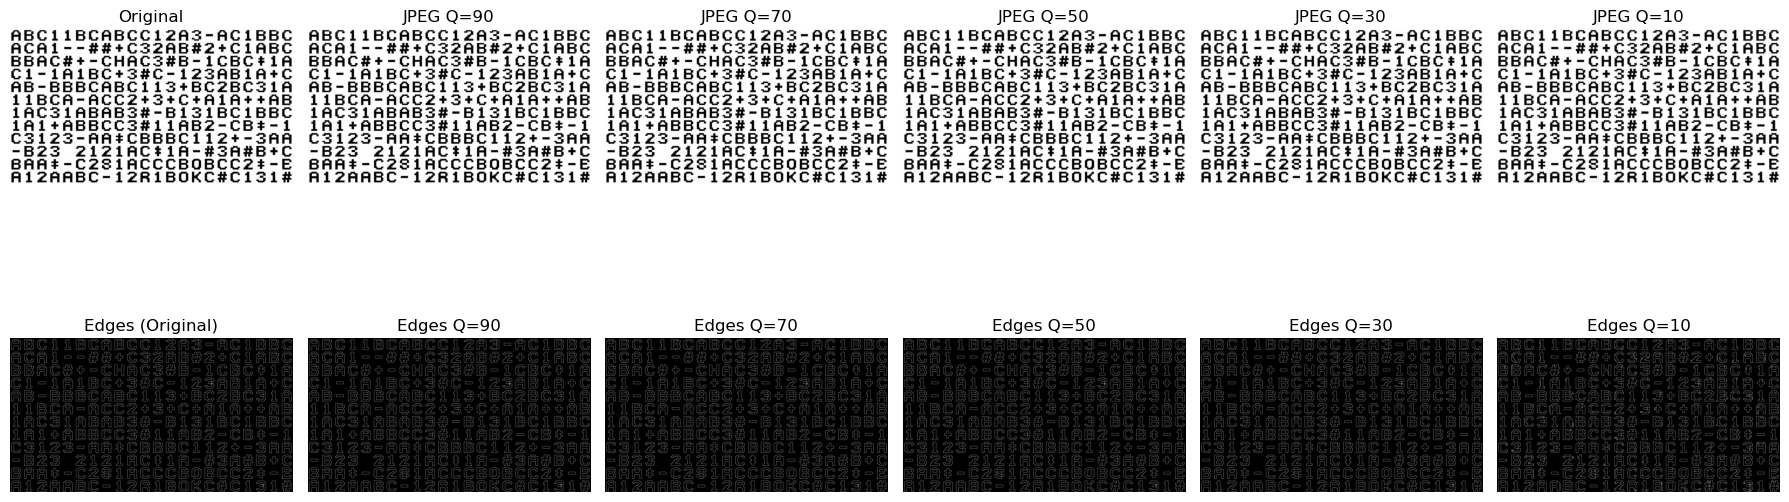


📊 QUALITY vs METRICS
Quality	PSNR		SSIM
-----------------------------------
90	47.14		0.9951
70	37.68		0.9664
50	35.12		0.9515
30	32.68		0.9282
10	27.51		0.8635


In [4]:
# ============================================================
# HUMAN-VISIBLE vs MACHINE-RELEVANT DIFFERENCES
#
# Tasks Covered:
# 1. Load grayscale image with text/patterns
# 2. Create JPEG compressed versions (different quality)
# 3. Compute PSNR and SSIM
# 4. Apply edge detection (machine-relevant task)
# 5. Compare perceptual metrics and algorithmic outputs
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os

# ------------------------------------------------------------
# CHANGE IMAGE PATH HERE
# ------------------------------------------------------------
IMAGE_PATH = "test.jpeg"   # <-- put your image path here

# JPEG quality levels to test
qualities = [90, 70, 50, 30, 10]

# ------------------------------------------------------------
# LOAD IMAGE
# ------------------------------------------------------------
original = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

if original is None:
    print("❌ Image not found")
    exit()

print("✅ Image loaded")

# Store results
compressed_images = []
metrics = []

# ------------------------------------------------------------
# JPEG COMPRESSION LOOP
# ------------------------------------------------------------
for q in qualities:

    filename = f"compressed_q{q}.jpg"
    cv2.imwrite(filename, original, [int(cv2.IMWRITE_JPEG_QUALITY), q])
    compressed = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # ---- PSNR & SSIM ----
    psnr_val = psnr(original, compressed)
    ssim_val = ssim(original, compressed)

    metrics.append((q, psnr_val, ssim_val))
    compressed_images.append(compressed)

    print(f"Quality {q} -> PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

# ------------------------------------------------------------
# EDGE DETECTION (Machine-relevant processing)
# ------------------------------------------------------------
edges_original = cv2.Canny(original, 100, 200)
edges_versions = [cv2.Canny(img, 100, 200) for img in compressed_images]

# ------------------------------------------------------------
# DISPLAY RESULTS
# ------------------------------------------------------------
plt.figure(figsize=(18, 10))

plt.subplot(3, len(qualities)+1, 1)
plt.title("Original")
plt.imshow(original, cmap="gray")
plt.axis("off")

for i, q in enumerate(qualities):
    plt.subplot(3, len(qualities)+1, i+2)
    plt.title(f"JPEG Q={q}")
    plt.imshow(compressed_images[i], cmap="gray")
    plt.axis("off")

plt.subplot(3, len(qualities)+1, len(qualities)+2)
plt.title("Edges (Original)")
plt.imshow(edges_original, cmap="gray")
plt.axis("off")

for i, q in enumerate(qualities):
    plt.subplot(3, len(qualities)+1, len(qualities)+3+i)
    plt.title(f"Edges Q={q}")
    plt.imshow(edges_versions[i], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# PRINT METRIC TABLE
# ------------------------------------------------------------
print("\n📊 QUALITY vs METRICS")
print("Quality\tPSNR\t\tSSIM")
print("-"*35)
for q, p, s in metrics:
    print(f"{q}\t{p:.2f}\t\t{s:.4f}")

### Task 3

In [1]:
import cv2
import os

# ------------------------------------------------------------
# INPUT IMAGE
# ------------------------------------------------------------
INPUT_IMG = "test.jpeg"

img = cv2.imread(INPUT_IMG, cv2.IMREAD_GRAYSCALE)

if img is None:
    print("❌ Image not found")
    exit()

print("✅ Original image loaded")

# ------------------------------------------------------------
# 1️⃣ LOSSLESS COMPRESSION (PNG)
# ------------------------------------------------------------
lossless_path = "test_lossless.png"

cv2.imwrite(
    lossless_path,
    img,
    [cv2.IMWRITE_PNG_COMPRESSION, 9]  # max compression, still lossless
)

print("✅ Lossless image saved as:", lossless_path)

# ------------------------------------------------------------
# 2️⃣ LOSSY COMPRESSION (JPEG)
# ------------------------------------------------------------
lossy_path = "test_lossy.jpeg"

cv2.imwrite(
    lossy_path,
    img,
    [cv2.IMWRITE_JPEG_QUALITY, 20]  # low quality → visible artifacts
)

print("✅ Lossy image saved as:", lossy_path)

# ------------------------------------------------------------
# FILE SIZE COMPARISON (optional but useful)
# ------------------------------------------------------------
orig_size = os.path.getsize(INPUT_IMG) / 1024
lossless_size = os.path.getsize(lossless_path) / 1024
lossy_size = os.path.getsize(lossy_path) / 1024

print("\n📦 File Sizes (KB)")
print(f"Original : {orig_size:.2f} KB")
print(f"Lossless : {lossless_size:.2f} KB")
print(f"Lossy    : {lossy_size:.2f} KB")


LOSSLESS_IMG = "test_lossless.png"
LOSSY_IMG    = "test_lossy.jpeg"


✅ Original image loaded
✅ Lossless image saved as: test_lossless.png
✅ Lossy image saved as: test_lossy.jpeg

📦 File Sizes (KB)
Original : 334.78 KB
Lossless : 541.77 KB
Lossy    : 109.79 KB


✅ Images loaded successfully
Lossless components: 263
Lossy components   : 263
🔥 Corrupted / distorted regions detected: 1954


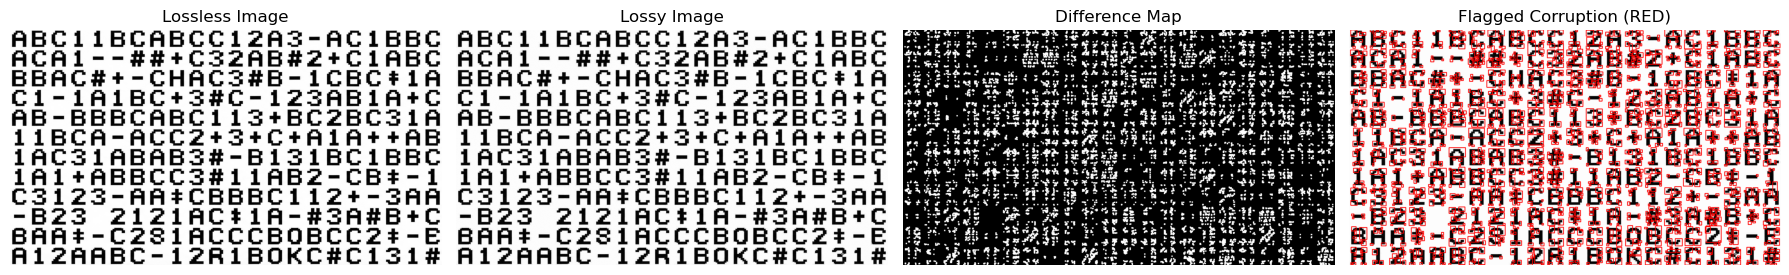

In [2]:
# ============================================================
# SILENT DATA CORRUPTION DETECTION
#
# Tasks covered:
# 1. Load two scanned versions of same document
# 2. Extract connected components / contours
# 3. Quantify structural differences (pixel-wise)
# 4. Flag regions where distortion/substitution occurred
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# LOAD IMAGES
# ------------------------------------------------------------
img1 = cv2.imread(LOSSLESS_IMG, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(LOSSY_IMG, cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    print("❌ One or both images not found")
    exit()

print("✅ Images loaded successfully")

# Resize if size mismatch
if img1.shape != img2.shape:
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# ------------------------------------------------------------
# BINARIZATION (for structure extraction)
# ------------------------------------------------------------
_, bin1 = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY_INV)
_, bin2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY_INV)

# ------------------------------------------------------------
# CONNECTED COMPONENTS (STRUCTURE EXTRACTION)
# ------------------------------------------------------------
num1, _, stats1, _ = cv2.connectedComponentsWithStats(bin1, connectivity=8)
num2, _, stats2, _ = cv2.connectedComponentsWithStats(bin2, connectivity=8)

print("Lossless components:", num1-1)
print("Lossy components   :", num2-1)

# ------------------------------------------------------------
# PIXEL-WISE DIFFERENCE (STRUCTURAL CHANGE)
# ------------------------------------------------------------
diff = cv2.absdiff(img1, img2)
_, diff_mask = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

# Remove small noise
kernel = np.ones((3,3), np.uint8)
diff_mask = cv2.morphologyEx(diff_mask, cv2.MORPH_DILATE, kernel, iterations=2)

# ------------------------------------------------------------
# FIND AND FLAG DISTORTED REGIONS
# ------------------------------------------------------------
contours, _ = cv2.findContours(diff_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

highlight = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

corrupted_count = 0

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w*h > 30:   # ignore very tiny noise
        cv2.rectangle(highlight, (x,y), (x+w, y+h), (0,0,255), 2)
        corrupted_count += 1

print("🔥 Corrupted / distorted regions detected:", corrupted_count)

# ------------------------------------------------------------
# DISPLAY RESULTS
# ------------------------------------------------------------
plt.figure(figsize=(18,6))

plt.subplot(1,4,1)
plt.title("Lossless Image")
plt.imshow(img1, cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Lossy Image")
plt.imshow(img2, cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Difference Map")
plt.imshow(diff_mask, cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Flagged Corruption (RED)")
plt.imshow(cv2.cvtColor(highlight, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

### Task 4

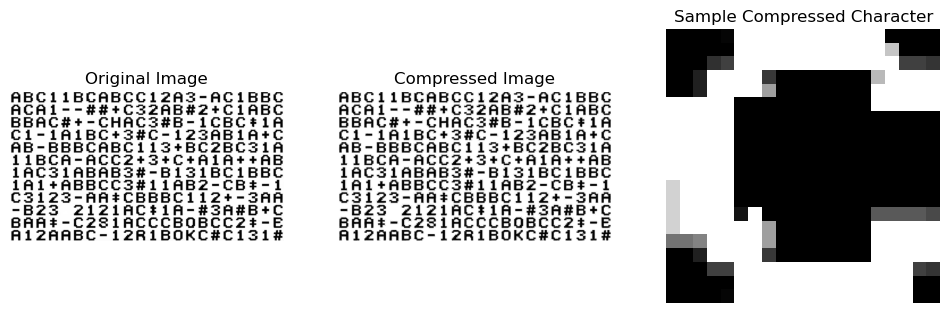

========== RESULTS ==========
Characters detected (Original): 263
Characters detected (Compressed): 265
Recognition Accuracy (Original):  0.86
Recognition Accuracy (Compressed): 0.91

Failures (Compressed Image):
{'I': 127, 'O': 100, 'X': 25, '-': 13}


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. LOAD ORIGINAL IMAGE
# -------------------------------------------------
img = cv2.imread("test.jpeg", cv2.IMREAD_GRAYSCALE)

# -------------------------------------------------
# 2. CREATE HEAVILY COMPRESSED IMAGE
# -------------------------------------------------
cv2.imwrite("doc_compressed.jpg", img, [cv2.IMWRITE_JPEG_QUALITY, 0])
img_comp = cv2.imread("doc_compressed.jpg", cv2.IMREAD_GRAYSCALE)

# -------------------------------------------------
# 3. BINARIZATION (OCR STYLE)
# -------------------------------------------------
_, bin_orig = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
_, bin_comp = cv2.threshold(img_comp, 127, 255, cv2.THRESH_BINARY_INV)

# -------------------------------------------------
# 4. CHARACTER EXTRACTION
# -------------------------------------------------
def extract_chars(binary):
    num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary)
    chars = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area > 20:
            roi = binary[y:y+h, x:x+w]
            roi = cv2.resize(roi, (20, 20))
            chars.append(roi)
    return chars

chars_orig = extract_chars(bin_orig)
chars_comp = extract_chars(bin_comp)

# -------------------------------------------------
# 5. RULE-BASED CHARACTER RECOGNIZER
# -------------------------------------------------
def recognize_char(img):
    vertical = np.sum(img[:, 9:11] > 0)
    horizontal = np.sum(img[9:11, :] > 0)

    contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    holes = 0
    if hierarchy is not None:
        for h in hierarchy[0]:
            if h[3] != -1:
                holes += 1

    if holes >= 1:
        return "O"
    elif vertical > horizontal:
        return "I"
    elif horizontal > vertical:
        return "-"
    else:
        return "X"   # failure / unknown

# -------------------------------------------------
# 6. RECOGNITION
# -------------------------------------------------
pred_orig = [recognize_char(c) for c in chars_orig]
pred_comp = [recognize_char(c) for c in chars_comp]

# -------------------------------------------------
# 7. ACCURACY MEASUREMENT
# -------------------------------------------------
def accuracy(pred):
    correct = sum(1 for p in pred if p != "X")
    return correct / len(pred) if len(pred) > 0 else 0

acc_orig = accuracy(pred_orig)
acc_comp = accuracy(pred_comp)

# -------------------------------------------------
# 8. FAILURE ANALYSIS
# -------------------------------------------------
failures = {}
for p in pred_comp:
    failures[p] = failures.get(p, 0) + 1

# -------------------------------------------------
# 9. VISUAL COMPARISON
# -------------------------------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_comp, cmap="gray")
plt.title("Compressed Image")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(chars_comp[0], cmap="gray")
plt.title("Sample Compressed Character")
plt.axis("off")

plt.show()

# -------------------------------------------------
# 10. PRINT RESULTS
# -------------------------------------------------
print("========== RESULTS ==========")
print("Characters detected (Original):", len(chars_orig))
print("Characters detected (Compressed):", len(chars_comp))
print("Recognition Accuracy (Original): ", round(acc_orig, 2))
print("Recognition Accuracy (Compressed):", round(acc_comp, 2))
print("\nFailures (Compressed Image):")
print(failures)


### Task 5

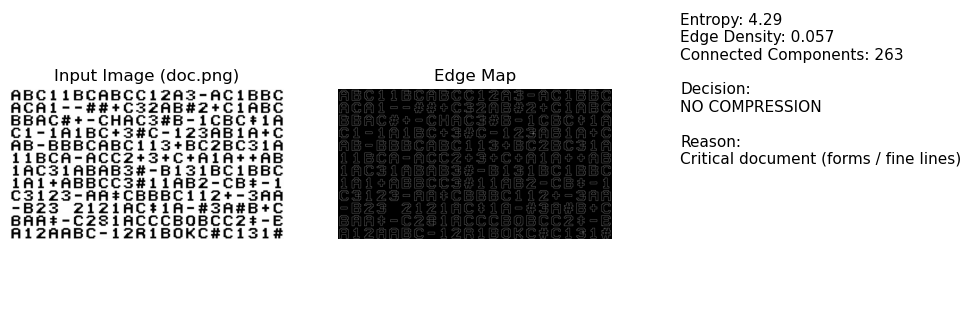

===== SAFE COMPRESSION ANALYSIS =====
Image: test.jpeg
Entropy: 4.29
Edge Density: 0.057
Connected Components: 263
Final Decision: NO COMPRESSION
Reason: Critical document (forms / fine lines)


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy

# ---------------------------------------------
# LOAD IMAGE (doc.png)
# ---------------------------------------------
image_path = "test.jpeg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise ValueError("doc.png not found!")

# ---------------------------------------------
# 1. ENTROPY
# ---------------------------------------------
entropy = shannon_entropy(img)

# ---------------------------------------------
# 2. EDGE DENSITY
# ---------------------------------------------
edges = cv2.Canny(img, 100, 200)
edge_density = np.sum(edges > 0) / edges.size

# ---------------------------------------------
# 3. CONNECTED COMPONENT COUNT
# ---------------------------------------------
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary)
cc_count = num_labels - 1   # remove background

# ---------------------------------------------
# 4. SAFE COMPRESSION DECISION RULE
# ---------------------------------------------
if cc_count > 500 and edge_density > 0.05:
    decision = "LOSSLESS COMPRESSION"
    reason = "Text-heavy document with many characters"
elif edge_density > 0.04 and entropy < 5:
    decision = "NO COMPRESSION"
    reason = "Critical document (forms / fine lines)"
else:
    decision = "LOSSY COMPRESSION"
    reason = "Low risk of structural damage"

# ---------------------------------------------
# 5. SHOW RESULTS
# ---------------------------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap="gray")
plt.title("Input Image (doc.png)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(edges, cmap="gray")
plt.title("Edge Map")
plt.axis("off")

plt.subplot(1,3,3)
plt.text(0.05, 0.5,
         f"Entropy: {entropy:.2f}\n"
         f"Edge Density: {edge_density:.3f}\n"
         f"Connected Components: {cc_count}\n\n"
         f"Decision:\n{decision}\n\n"
         f"Reason:\n{reason}",
         fontsize=11)
plt.axis("off")

plt.show()

# ---------------------------------------------
# 6. PRINT SUMMARY (FOR EXAM OUTPUT)
# ---------------------------------------------
print("===== SAFE COMPRESSION ANALYSIS =====")
print("Image:", image_path)
print("Entropy:", round(entropy, 2))
print("Edge Density:", round(edge_density, 3))
print("Connected Components:", cc_count)
print("Final Decision:", decision)
print("Reason:", reason)
